In [98]:
%matplotlib inline
from matplotlib import pyplot as plt

In [117]:
import yaml
import numpy as np
# import csv
from glob import glob
import cv2

In [118]:
%ls cam0

data/        data.csv*    sensor.yaml*


In [119]:
def getYaml(file):
    with open(file, 'r') as f:
        doc = yaml.safe_load(f)
    return doc

In [120]:
body = getYaml('body.yaml')
print(body)
# c0 = getYaml('cam0/sensor.yaml')
# c1 = getYaml('cam1/sensor.yaml')

{'comment': 'Asctec Firefly MAV'}


In [68]:
# print(c0)
# print(cam1)

{'sensor_type': 'camera', 'comment': 'VI-Sensor cam0 (MT9M034)', 'T_BS': {'cols': 4, 'rows': 4, 'data': [0.0148655429818, -0.999880929698, 0.00414029679422, -0.0216401454975, 0.999557249008, 0.0149672133247, 0.025715529948, -0.064676986768, -0.0257744366974, 0.00375618835797, 0.999660727178, 0.00981073058949, 0.0, 0.0, 0.0, 1.0]}, 'rate_hz': 20, 'resolution': [752, 480], 'camera_model': 'pinhole', 'intrinsics': [458.654, 457.296, 367.215, 248.375], 'distortion_model': 'radial-tangential', 'distortion_coefficients': [-0.28340811, 0.07395907, 0.00019359, 1.76187114e-05]}


In [106]:
class CameraModel(object):
    def __init__(self, file):
        data = getYaml(file)
        self.shape = (data['T_BS']['rows'], data['T_BS']['cols'],)
        self.T_BS = np.array(data['T_BS']['data']).reshape(*self.shape)
        self.D = np.array(data['distortion_coefficients'])
        t = data['intrinsics']
        self.K = np.eye(3)
        self.K[0,0] = t[0]
        self.K[1,1] = t[1]
        self.K[0,2] = t[2]
        self.K[1,2] = t[3]
        self.rate_hz = data['rate_hz']

In [107]:
cam0 = CameraModel('cam0/sensor.yaml')
cam1 = CameraModel('cam1/sensor.yaml')

In [108]:
cam0.T_BS

array([[ 0.01486554, -0.99988093,  0.0041403 , -0.02164015],
       [ 0.99955725,  0.01496721,  0.02571553, -0.06467699],
       [-0.02577444,  0.00375619,  0.99966073,  0.00981073],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [82]:
cam1.T_BS

array([[ 0.01255527, -0.9997551 ,  0.01822377, -0.01984356],
       [ 0.99959878,  0.01301191,  0.02515884,  0.04536894],
       [-0.0253898 ,  0.01790058,  0.99951735,  0.00786212],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [84]:
# with open('cam0/data.csv', newline='') as csvfile:
#     data = csv.reader(csvfile, delimiter=' ', quotechar='|')

In [110]:
# files = glob("cam0/data/*.png")
# print("Number files found:", len(files))

In [112]:
def getImgs(path):
    files = glob(path)
    print("{} has {} images".format(path, len(files)))
    imgs = []
    timestamps = []
    for f in files:
        ts = int(f.split("/")[2].split(".")[0])
        timestamps.append(ts)
        im = cv2.imread(f)
        imgs.append(im)
    return imgs, timestamps

In [91]:
# f = files[0]
# ts = int(f.split("/")[2].split(".")[0])

In [113]:
left, ts = getImgs("cam0/data/*.png")
right, ts = getImgs("cam1/data/*.png")

cam0/data/*.png has 2912 images
cam1/data/*.png has 2912 images


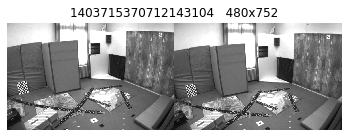

In [116]:
num = 2000
plt.imshow(np.hstack((left[num], right[num])))
title = "{}   {}x{}".format(ts[num],*left[num].shape)
plt.title(title)
plt.axis('off');

In [132]:
# This is just a collection of different feature detectors
def FAST(im):
    fast = cv2.FastFeatureDetector_create()
    fast.setNonmaxSuppression(True)
    fast.setThreshold(5)  # 20
    # find and draw the keypoints
    keypoints = fast.detect(im)
    keypoints=np.array([[k.pt] for k in keypoints],dtype='f4')  # int?
    
    
    # keypoints = sorted(kp1, key = lambda x:x.response, reverse=True)[:numCorners]
    # keypoints = np.array([k.pt for k in keypoints], dtype='int')
    
    return keypoints

def ORB(im):
    # this seems to loose points quickly
    orb = cv2.ORB_create()
    keypoints = orb.detect(im,None)
    keypoints=np.array([[k.pt] for k in keypoints],dtype='f4')
    return keypoints

def ShiTomasi(im):
    # params for ShiTomasi corner detection
    feature_params = dict( maxCorners = 500,
        qualityLevel = 0.3,
        minDistance = 7,
        blockSize = 7 )
    keypoints = cv2.goodFeaturesToTrack(im, mask = None, **feature_params)
    return keypoints

def featureDetection(im, method=0):
    """
    This initializes the feature to track OR finds new features when the 
    current group of tracked features falls off the image plane (or said
    anther way, are no longer in the image).
    """
    method = 0
    keypoints = None
    if method == 0:
        keypoints = FAST(im)
    elif method == 1:
        keypoints = ORB(im)
    elif method == 2:
        keypoints = ShiTomasi(im)
    else:
        print('ERROR: no method selected for feature detection')

    return keypoints

In [133]:
def featureTrack(new_gray,old_gray,p0):
    """
    Given some initial feature (p0) find the new location of those 
    features in the new image. All images are grayscale.
    """
    # Parameters for lucas kanade optical flow
    lk_params = dict(
        winSize  = (10,10),
        maxLevel = 3,
        criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)
    )

    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, new_gray, p0, None, **lk_params)

    # good points have st==1, so weed out the bad
    new = p0[st==1]
    old = p1[st==1]
    
    p1 = np.array([[k] for k in new],dtype=np.float32)
    p0 = np.array([[k] for k in old],dtype=np.float32)

    return p0, p1

In [134]:
def stereo_match_feature(left_img, right_img, patch_radius, keypoints, min_disp, max_disp):
    # in case you want to find stereo match by yourself
    h, w = left_img.shape
    num_points = keypoints.shape[0]

    # Depth (or disparity) map
    depth = np.zeros(left_img.shape, np.uint8)
    output = np.zeros(keypoints.shape, dtype='int')
    all_index = np.zeros((keypoints.shape[0],1), dtype='int').reshape(-1)

    r     = patch_radius
    # patch_size = 2*patch_radius + 1;

    for i in range(num_points):

        row, col = keypoints[i,0], keypoints[i,1]
        # print(row, col)
        best_offset = 0;
        best_score = float('inf');

        if (row-r < 0 or row + r >= h or col - r < 0 or col + r >= w): continue

        left_patch = left_img[(row-r):(row+r+1), (col-r):(col+r+1)] # left imag patch

        all_index[i] = 1

        for offset in range(min_disp, max_disp+1):

              if (row-r) < 0 or row + r >= h or  (col-r-offset) < 0 or (col+r-offset) >= w:
                    continue

              diff  = left_patch - right_img[(row-r):(row+r+1), (col-r-offset):(col+r-offset+1)]
              sum_s = np.sum(diff**2)

              if sum_s < best_score:
                  best_score = sum_s
                  best_offset = offset

        output[i,0], output[i,1] = row,col-best_offset

    return output, all_index

In [135]:
def removeDuplicate(queryPoints, refPoints, radius=5):
    #remove duplicate points from new query points,
    for i in range(len(queryPoints)):
        query = queryPoints[i]
        xliml, xlimh = query[0]-radius, query[0]+radius
        yliml, ylimh = query[1]-radius, query[1]+radius
        inside_x_lim_mask = (refPoints[:,0] > xliml) & (refPoints[:,0] < xlimh)
        curr_kps_in_x_lim = refPoints[inside_x_lim_mask]

        if curr_kps_in_x_lim.shape[0] != 0:
            inside_y_lim_mask = (curr_kps_in_x_lim[:,1] > yliml) & (curr_kps_in_x_lim[:,1] < ylimh)
            curr_kps_in_x_lim_and_y_lim = curr_kps_in_x_lim[inside_y_lim_mask,:]
            if curr_kps_in_x_lim_and_y_lim.shape[0] != 0:
                queryPoints[i] =  np.array([0,0])
    return (queryPoints[:, 0]  != 0 )

In [161]:
def extract_keypoints_surf(img1, img2, K, baseline, refPoints = None):
#     detector = cv2.xfeatures2d.SURF_create(400)
    detector = cv2.ORB_create()
#     detector = cv2.FastFeatureDetector_create()
#     detector.setNonmaxSuppression(True)
#     detector.setThreshold(5)  # 20
    
    kp1, desc1 = detector.detectAndCompute(img1, None)
    kp2, desc2 = detector.detectAndCompute(img2, None)
    
    print(desc1.shape, desc2.shape)
    print(type(desc1[0][0]))

    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)   # or pass empty dictionary
    flann = cv2.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(desc1.astype(np.float32),desc2.astype(np.float32),k=2)

    # ratio test as per Lowe's paper
    match_points1, match_points2 = [], []
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.7*n.distance:
            match_points1.append(kp1[m.queryIdx].pt)
            match_points2.append(kp2[m.trainIdx].pt)

    p1 = np.array(match_points1).astype(float)
    p2 = np.array(match_points2).astype(float)

    if refPoints is not None:
        mask = removeDuplicate(p1, refPoints)
        p1 = p1[mask,:]
        p2 = p2[mask,:]

    # 3x4 homogenous matrix for left/right camera
    M_left = K.dot(np.hstack((np.eye(3), np.zeros((3,1)))))
    M_rght = K.dot(np.hstack((np.eye(3), np.array([[-baseline,0, 0]]).T)))
    # rearrange to make function work
    p1_flip = np.vstack((p1.T,np.ones((1,p1.shape[0]))))
    p2_flip = np.vstack((p2.T,np.ones((1,p2.shape[0]))))
    # reconstruct 3d points from camera matrices and points, returns 4xN pts (homogenous)
    P = cv2.triangulatePoints(M_left, M_rght, p1_flip[:2], p2_flip[:2])
    # these are 4d points, convert to 3d by dividing by the last element
    P = P/P[3]
    pts_3d = P[:3]

    return pts_3d.T, p1

In [141]:
def featureTracking(img_1, img_2, p1, world_points):
    # use KLT tracker
    lk_params = dict( winSize  = (21,21),
                      maxLevel = 3,
                      criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01))

    p2, st, err = cv2.calcOpticalFlowPyrLK(img_1, img_2, p1, None, **lk_params)
    st = st.reshape(st.shape[0])
    # find good one
    pre = p1[st==1]
    p2 = p2[st==1]
    w_points = world_points[st==1]  # ??????

    return w_points, pre,p2

In [165]:
def playImageSequence(images, K, baseline):
    '''
        different ways to initialize the query points and landmark points
        you can specify the keypoints and landmarks
        or you can inilize_3D with FAST corner points, then stere match and 
        then generate 3D points, but not so accurate
        or you can use the OPENCV feature extraction and matching functions
    '''
    
    ret_pos = []
    left_img, right_img = images[0]

    points, p1 = extract_keypoints_surf(left_img, right_img, K, baseline)
    p1 = p1.astype('float32')

    pnp_objP = np.expand_dims(points, axis = 2)
    pnp_p1   = np.expand_dims(p1, axis = 2).astype(float)

    # reference
    reference_img = left_img
    reference_2D  = p1
    landmark_3D   = points

    # _, rvec, tvec = cv2.solvePnP(pnp_objP, pnp_p1, K, None)

    for i, (left_img, right_img) in enumerate(images):
        if i % 20 == 0:
            print('image: ', i)

        # track points through left image
        landmark_3D, reference_2D, tracked_2Dpoints = featureTracking(
            reference_img, 
            left_img, # curImage, 
            reference_2D,  
            landmark_3D)
        print(landmark_3D.shape)

        pnp_objP = np.expand_dims(landmark_3D, axis = 2)
        pnp_cur  = np.expand_dims(tracked_2Dpoints, axis = 2).astype(float)

        # try to estimate object pose given current image points
        _, rvec, tvec, inliers = cv2.solvePnPRansac(pnp_objP , pnp_cur, K, None)

        # update the new reference_2D
        reference_2D = tracked_2Dpoints[inliers[:,0],:]
        landmark_3D  = landmark_3D[inliers[:,0],:]

        # retrieve the rotation matrix
        rot,_ = cv2.Rodrigues(rvec)
        tvec = -rot.T.dot(tvec)     # coordinate transformation, from camera to world

        inv_transform = np.hstack((rot.T,tvec)) # inverse transform

        inliers_ratio = len(inliers)/len(pnp_objP) # the inlier ratio
#         print('inliers ratio: ',inliers_ratio)

        # re-obtain the 3 D points if the conditions satisfied
        # calculate distance tracked keypoints have moved
        if (inliers_ratio < 0.9 or len(reference_2D) < 50):
            # initiliazation new landmarks
            
            # landmark_3D, reference_2D = initiliazatize_3D_points(curImage, 
            #   curImage_R, K, baseline)
            # reference_2D = np.fliplr(reference_2D).astype('float32')
            
            landmark_3D_new, reference_2D_new = extract_keypoints_surf(
                left_img,   #curImage, 
                right_img,  # curImage_R, 
                K, 
                baseline, 
                reference_2D)
            # ???
            reference_2D_new = reference_2D_new.astype('float32')
            landmark_3D_new = inv_transform.dot(
                np.vstack((landmark_3D_new.T, np.ones((1,landmark_3D_new.shape[0]))))
            )
            valid_matches = landmark_3D_new[2,:] >0
            landmark_3D_new = landmark_3D_new[:,valid_matches]

            reference_2D = np.vstack((reference_2D, reference_2D_new[valid_matches,:]))
            landmark_3D =  np.vstack((landmark_3D, landmark_3D_new.T))
#         else:
#             print("*** failed conditions ***")

        reference_img = left_img
        ret_pos.append((tvec[0], tvec[2]))
    
    return ret_pos

In [166]:
imgs = [(l,r) for l,r in zip(left,right)]
k = cam0.K
baseline = 0.54
pts = playImageSequence(imgs, k, baseline)

(500, 32) (500, 32)
<class 'numpy.uint8'>
image:  0
(106, 3)
(7, 3)


TypeError: 'NoneType' object is not subscriptable